# Cab-Driver Agent
Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

## Set-up

### Google Collab Set-up Code

#### Mounting Google Drive to Google Collab

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

#### Choosing Tensorflow 1.x version

In [2]:
# %tensorflow_version 1.x

#### Changing present working directory to project directory

In [3]:
# cd /content/drive/My Drive/Cab Driver Profit Maximization Case Study/

## Importing libraries

In [4]:
# Importing libraries
import numpy as np
import os
import random
import math
from collections import deque
import collections
import pickle
import time
import warnings

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import Callback

from collections import Counter

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Defining Time Matrix

In [5]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

## Defining Functions

### For Common Utility

In [6]:
# Defining a function to save the obj as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def create_dir(dir_name):
    # make dir to store model weights
    if not os.path.exists(dir_name):
        os.mkdir(dir_name) 

def read_obj(name):
    with open('{}.pkl'.format(name), 'rb') as f:
        obj = pickle.load(f)

    return obj  

### To convert state array into a string to store it as keys in the dictionary

In [7]:
def Q_state(state):
    return ('-'.join(str(e) for e in state))

### To add new Q-values to the Q-dictionary

In [8]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state, actions):
    state_key = Q_state(state)
    
    if state_key not in Q_dict.keys():
        for action in actions:
            Q_dict[state_key][action] = 0
            States_track[state_key][action] = []

### To populate Q-values to the Q-dictionary

In [9]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def populate_dicts(state, action, action_predicted_q_value):
    state_key = Q_state(state)
    if state_key in Q_dict.keys():
        Q_dict[state_key][action] = action_predicted_q_value
        States_track[state_key][action].append(Q_dict[state_key][action])

### To get common tracked state-action pairs

In [10]:
def get_common_state_action(tracked_states, most_common = True, common_count = 5):
    state_action_pair = []
    for state in tracked_states.keys():
        for action, values in tracked_states[state].items():
            values = list(filter(lambda x: x != 0, values))
            if len(values) > 0:
                state_action_pair.append((state, action, len(values)))
            
    most_common_state_action_pair = list(sorted(state_action_pair, key = lambda x: x[2], reverse = most_common))
    most_common_state_action_pair = most_common_state_action_pair[:common_count]
    return most_common_state_action_pair

### To populate common state-action pairs for checking convergence

In [11]:
def populate_common_state_action_track(tracked_states, threshold = 1, most_common = True, common_count = 5):
    common_states_track_dict = collections.defaultdict(dict)
    common_state_action_pair = get_common_state_action(tracked_states, most_common, common_count)
    
    for state_action in common_state_action_pair:
        state = state_action[0]
        action = state_action[1]

        if state not in common_states_track_dict.keys() or action not in common_states_track_dict[state]:
            common_states_track_dict[state][action] = []
        
        for index, value in enumerate(tracked_states[state][action]):
            if ((index + 1) % threshold) == 0:
                common_states_track_dict[state][action].append(value)

    return common_state_action_pair, common_states_track_dict

### To initialise values

In [12]:
def initialise_values(file_name, initialise_from_file = False):
    obj = []
    if initialise_from_file and os.path.exists(file_name + '.pkl'):
        obj = read_obj(file_name)

    return obj

### To initialise dicts

In [13]:
def initialise_dicts(file_name, initialise_from_file = False):
    obj = collections.defaultdict(dict)
    if initialise_from_file and os.path.exists(file_name + '.pkl'):
        obj = read_obj(file_name)

    return obj 

### To initialise model filename

In [14]:
def initialise_model_filename(file_name, initialise_from_file = False):
    model_file_name = None
    if initialise_from_file and os.path.exists(file_name):
        model_file_name = file_name

    return model_file_name

## Defining loss callback

In [15]:
class LossHistory(Callback):
    def __init__(self, losses):
        self.losses = losses
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

## Defining Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [16]:
class DQNAgent:
    def __init__(self, state_size, action_size, 
                 initial_epsilon = 1.0,
                 epsilon_min = 0,
                 epsilon_decay = 0.0009,
                 action_counter = 0, 
                 debug = False, is_training = True, 
                 saved_model_path = None, loss_callback = LossHistory([])):
        self.debug = debug
        self.is_training = is_training
        
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001 
        self.epsilon_max = 1.0
        
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.action_counter = action_counter

        self.loss_callback = loss_callback
        
        self.batch_size = 64   

        # create replay memory using deque
        # Approx. 20% of all experience that will be generated for 15k episodes
        self.memory = deque(maxlen = 600000)
        
        if self.is_training:
            self.epsilon = initial_epsilon
        else:
            self.epsilon = self.epsilon_min
            
        # create main model and target model
        if saved_model_path:
            print('Loading model from : {}'.format(saved_model_path))
            self.model = load_model(saved_model_path, compile = False)
            print('Model successfully loaded')
        else:
            self.model = self.build_model()


    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon = round(self.epsilon_min + 
                                 (self.epsilon_max - self.epsilon_min) * 
                                 np.exp(-1*self.epsilon_decay*self.action_counter), 3)
        else:
            self.epsilon = self.epsilon_min
    

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))    
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate), metrics = ['mse'])
        print(model.summary())
        return model
    

    def get_action(self, state, possible_actions_index):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment  
        self.action_counter += 1
        
        if self.debug:
            print('\nAction Counter : {}'.format(self.action_counter))
            print('Epsilon value : {}'.format(self.epsilon))
            print('Possible Actions Index : {}'.format(possible_actions_index))
            
        # the first index corresponds to the batch size, so
        # reshape state to (1, state_size) so that the first index corresponds to the batch size
        state = np.array(state).reshape(1, self.state_size)
        q_values = self.model.predict(state)[0]
        z = round(np.random.rand(), 3)

        if self.debug:
            print('z value : {}'.format(z))
        
        if z <= self.epsilon:
            # explore: choose a random action from all possible actions
            overall_possible_action_index = random.choice(possible_actions_index)
            
            if self.debug:
                print('Exploration Overall Action Index : {}'.format(overall_possible_action_index))
        else:
            # choose the action with the highest q(s, a) within possible actions
            possible_q_values = [q_values[action_index] for action_index in possible_actions_index]
            selected_possible_action_index = np.argmax(possible_q_values)
            overall_possible_action_index = possible_actions_index[selected_possible_action_index]

            if self.debug:
                print('Predicted Possible Q-values : {}'.format(possible_q_values))
                print('Selected Possible Action Index : {}'.format(selected_possible_action_index))
                print('Exploitation Overall Action Index : {}'.format(overall_possible_action_index))

        selected_possible_action_q_value = q_values[overall_possible_action_index]

        if self.debug:
            print('Selected Possible Action Q Value : {}'.format(selected_possible_action_q_value))
            
        return overall_possible_action_index, selected_possible_action_q_value
        
        
    def append_sample(self, state, action, reward, next_state, terminated):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, terminated))
        self.update_epsilon()
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        memory_size = len(self.memory)
        
        if self.debug:
            print('\nCurrent Memory Size : {}'.format(memory_size))
            print('Batch Size : {}'.format(self.batch_size))
            
        
        if  memory_size > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                 # Write your code from here
                state, action, reward, next_state, terminated = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                done.append(terminated)

             # 1. Predict the target from earlier model
            target = self.model.predict(update_input)

            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
            
            if self.debug:
                print('Target Size : {}'.format(len(target)))
                print('Target Q Value Size : {}'.format(len(target_qval)))

            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # 4. Fit your model and track the loss values
            if self.debug:
                print('Training model :')
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0, 
                           callbacks = [self.loss_callback])
            if self.debug:
                print('Model successfully updated :')
            

    def save(self, name):
        self.model.save(name)

## Defining input files

In [17]:
# Defining input dir
input_dir = "input"

# Defining initial file names used for initialising
initial_states_tracked_filename = '{}/States_tracked'.format(input_dir)
initial_policy_filename = '{}/Policy'.format(input_dir)
initial_rewards_per_episode_filename = "{}/rewards_per_episode".format(input_dir)
initial_trips_per_episode_filename = "{}/trips_per_episode".format(input_dir)
initial_offline_actions_per_episode_filename = "{}/offline_actions_per_episode".format(input_dir)
initial_epsilons_filename = "{}/epsilons".format(input_dir)
initial_model_filename = "./{}/model.h5".format(input_dir)
initial_training_loss_filename = "{}/training_loss".format(input_dir)

## Defining output files

In [18]:
# Defining output dir
output_dir = "output"

# Defining final file names used for testing
final_all_states_tracked_filename = '{}/States_tracked'.format(output_dir)
final_most_common_states_tracked_filename = '{}/Most_common_states_tracked'.format(output_dir)
final_policy_filename = '{}/Policy'.format(output_dir)
final_rewards_per_episode_filename = "{}/rewards_per_episode".format(output_dir)
final_trips_per_episode_filename = "{}/trips_per_episode".format(output_dir)
final_offline_actions_per_episode_filename = "{}/offline_actions_per_episode".format(output_dir)
final_epsilons_filename = "{}/epsilons".format(output_dir)
final_model_filename = "./{}/model.h5".format(output_dir)
final_training_loss_filename = "./{}/training_loss".format(output_dir)
final_rewards_filename = '{}/rewards.png'.format(output_dir)
final_trips_filename = '{}/trips.png'.format(output_dir)
final_offline_actions_filename = '{}/offline_actions.png'.format(output_dir)
final_loss_filename = '{}/loss.png'.format(output_dir)
final_most_common_state_actions_filename = '{}/most_common_state_actions'.format(output_dir)

## Defining parameters

In [0]:
total_available_hours = 24*30                 # for 30 days

initial_episode = 0

# total_episodes = 100
# epsilon_decay = 0.0004

total_episodes = 15000
epsilon_decay = 0.000002

debug = False

# every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
threshold = 1000

## Initialising values

In [0]:
# Initialising dicts
Q_dict = initialise_dicts(initial_policy_filename, False)
States_track = initialise_dicts(initial_states_tracked_filename, False)

# Initialising tracking values
rewards_per_episode = initialise_values(initial_rewards_per_episode_filename, False)
trips_per_episode = initialise_values(initial_trips_per_episode_filename, False)
epsilons = initialise_values(initial_epsilons_filename, False)
offline_actions_per_episode = initialise_values(initial_offline_actions_per_episode_filename, False)
losses = initialise_values(initial_training_loss_filename, False)
input_model_filename = initialise_model_filename(initial_model_filename, False)

# Initialising epsilon
initial_epsilon = epsilons[-1] if len(epsilons) > 0 else 1.0

# Call the environment
env = CabDriver(Time_matrix, debug = debug)
    
# Call all the initialised variables of the environment
state_size = env.state_size
action_size = len(env.action_space)

# Initialising loss callback
loss_callback = LossHistory(losses)

# Call the DQN agent
agent = DQNAgent(action_size = action_size, state_size = state_size, 
                 initial_epsilon = initial_epsilon,
                 epsilon_decay = epsilon_decay, action_counter = len(epsilons), 
                 saved_model_path = input_model_filename,
                 debug = debug, loss_callback = loss_callback)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________
None


## DQN block (Training)

In [0]:
start_time = time.time()

# Defining different dirs 
training_dir = "training_{}".format(start_time)
tracking_dir = "{}/tracking".format(training_dir)
saved_models_dir = "{}/saved_models".format(training_dir)

# Defining different file names for tracking
states_tracked_filename = '{}/States_tracked'.format(tracking_dir)
policy_filename = '{}/Policy'.format(tracking_dir)
rewards_per_episode_filename = "{}/rewards_per_episode".format(tracking_dir)
trips_per_episode_filename = "{}/trips_per_episode".format(tracking_dir)
offline_actions_per_episode_filename = "{}/offline_actions_per_episode".format(tracking_dir)
epsilons_filename = "{}/epsilons".format(tracking_dir)
training_loss_filename = "./{}/training_loss".format(tracking_dir)

# Creating different dirs 
create_dir(training_dir) 
create_dir(tracking_dir)
create_dir(saved_models_dir)
create_dir(output_dir)

episode_batch_start_time = time.time()

for episode in range(initial_episode, total_episodes):
    state = env.reset()

    if debug:
        print('\nBeginning Episode : {}'.format(episode + 1))
        print('Initial State : {}'.format(state))

    add_to_dict(state, env.action_space)

    total_reward = 0
    total_time_taken = 0
    terminal_state = False
    total_trips = 0
    total_offline_actions = 0

    while not terminal_state:        
        encoded_state = env.state_encod_arch1(state)

        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_index, possible_actions = env.requests(state)
        epsilons.append(agent.epsilon)
        selected_action_index, action_predicted_q_value = agent.get_action(encoded_state, possible_actions_index)
        action = env.action_space[selected_action_index]

        if selected_action_index == 20:
            total_offline_actions += 1 

        populate_dicts(state, action, action_predicted_q_value)

        # 2. Evaluate your reward and next state
        next_state, reward, time_taken = env.step(state, action)
        total_time_taken += time_taken
        terminal_state = (total_time_taken >= total_available_hours)

        add_to_dict(next_state, env.action_space)

        encoded_next_state = env.state_encod_arch1(next_state)

        # 3. Append the experience to the memory
        agent.append_sample(encoded_state, selected_action_index, reward, 
                            encoded_next_state, terminal_state)

        # 4. Train the model by calling function agent.train_model
        agent.train_model()

        # add reward to the total score of this episode
        total_reward += reward
        total_trips += 1
        state = next_state

    # 5. Keep a track of rewards, Q-values, loss
    rewards_per_episode.append(total_reward)
    trips_per_episode.append(total_trips)
    offline_actions_per_episode.append(total_offline_actions)

    if ((episode+1) % threshold) == 0:   #every threshold episode
        # save tracking states
        save_obj(States_track, states_tracked_filename) 

        # save model
        model_filename = "./{}/model_{}.h5".format(saved_models_dir, episode)
        agent.save(name=model_filename)

        # save rewards per episode
        save_obj(rewards_per_episode, rewards_per_episode_filename)

        # save trips per episode
        save_obj(trips_per_episode, trips_per_episode_filename)

        # save offline actions per episode
        save_obj(offline_actions_per_episode, offline_actions_per_episode_filename)

        # save epsilons
        save_obj(epsilons, epsilons_filename)

        # save loss
        save_obj(loss_callback.losses, training_loss_filename)

        # saving policy
        save_obj(Q_dict, policy_filename)

        episode_batch_end_time = time.time()
        episode_batch_elapsed_time = episode_batch_end_time - episode_batch_start_time
        episode_batch_start_time = episode_batch_end_time

        print("Episodes processed : {},".format(episode + 1), 
              "Current epsilon : {},".format(agent.epsilon),
              "For last {} episodes - Avg. reward : {}, Avg. trips : {}, Avg. offline actions : {}, Elapsed Time : {}".format(threshold, 
                                                                                                    np.mean(rewards_per_episode[(-1*threshold):]),
                                                                                                    np.mean(trips_per_episode[(-1*threshold):]),
                                                                                                    np.mean(offline_actions_per_episode[(-1*threshold):]),
                                                                                                    episode_batch_elapsed_time)
              )

# save tracking states
# For tracking (this would remain safe as getting saved in folder suffixed with timestamp)
save_obj(States_track, states_tracked_filename)

# For Testing (this would get overwritten on subsequent runs)
save_obj(States_track, final_all_states_tracked_filename)


# saving policy
# For tracking (this would remain safe as getting saved in folder suffixed with timestamp)
save_obj(Q_dict, policy_filename)

# For Testing (this would get overwritten on subsequent runs)
save_obj(Q_dict, final_policy_filename)


# save model
# For tracking (this would remain safe as getting saved in folder suffixed with timestamp)
model_filename = "./{}/model_{}.h5".format(saved_models_dir, total_episodes)
agent.save(name = model_filename)

# For Testing (this would get overwritten on subsequent runs)
agent.save(name = final_model_filename)


# save rewards per episode
# For tracking (this would remain safe as getting saved in folder suffixed with timestamp)
save_obj(rewards_per_episode, rewards_per_episode_filename)

# For Testing (this would get overwritten on subsequent runs)
save_obj(rewards_per_episode, final_rewards_per_episode_filename)


# save trips per episode
# For tracking (this would remain safe as getting saved in folder suffixed with timestamp)
save_obj(trips_per_episode, trips_per_episode_filename)

# For Testing (this would get overwritten on subsequent runs)
save_obj(trips_per_episode, final_trips_per_episode_filename)


# save offline actions per episode
# For tracking (this would remain safe as getting saved in folder suffixed with timestamp)
save_obj(offline_actions_per_episode, offline_actions_per_episode_filename)

# For Testing (this would get overwritten on subsequent runs)
save_obj(offline_actions_per_episode, final_offline_actions_per_episode_filename)


# save loss
# For tracking (this would remain safe as getting saved in folder suffixed with timestamp)
save_obj(loss_callback.losses, training_loss_filename)

# For Testing (this would get overwritten on subsequent runs)
save_obj(loss_callback.losses, final_training_loss_filename)


# save epsilons
# For tracking (this would remain safe as getting saved in folder suffixed with timestamp)
save_obj(epsilons, epsilons_filename)

# For Testing (this would get overwritten on subsequent runs)
save_obj(epsilons, final_epsilons_filename)


elapsed_time = time.time() - start_time
print('Total Elapsed Time : {}'.format(elapsed_time))


Episodes processed : 1000, Current epsilon : 0.749, For last 1000 episodes - Avg. reward : -4.902, Avg. trips : 144.292, Avg. offline actions : 32.921, Elapsed Time : 823.0241100788116
Episodes processed : 2000, Current epsilon : 0.546, For last 1000 episodes - Avg. reward : 306.47, Avg. trips : 158.083, Avg. offline actions : 38.255, Elapsed Time : 936.3611671924591
Episodes processed : 3000, Current epsilon : 0.389, For last 1000 episodes - Avg. reward : 605.855, Avg. trips : 170.055, Avg. offline actions : 43.838, Elapsed Time : 1092.224385023117
Episodes processed : 4000, Current epsilon : 0.271, For last 1000 episodes - Avg. reward : 887.105, Avg. trips : 180.541, Avg. offline actions : 49.306, Elapsed Time : 1348.0507247447968
Episodes processed : 5000, Current epsilon : 0.186, For last 1000 episodes - Avg. reward : 1101.446, Avg. trips : 188.201, Avg. offline actions : 54.298, Elapsed Time : 1426.6602230072021
Episodes processed : 6000, Current epsilon : 0.127, For last 1000 ep

## Tracking Convergence

### Rewards

#### Reading Rewards per episode file

In [0]:
final_rewards_per_episode = read_obj(final_rewards_per_episode_filename)

#### Plotting episode vs rewards 

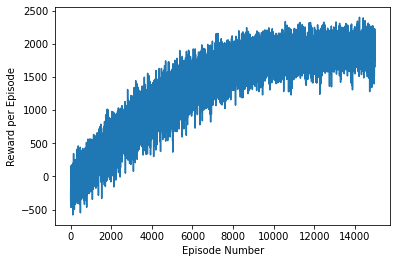

In [0]:
plt.plot(list(range(len(final_rewards_per_episode))), final_rewards_per_episode)
plt.xlabel("Episode Number")
plt.ylabel("Reward per Episode")

# save plots in saved_plots/ directory
plt.savefig(final_rewards_filename)

#### Average reward of last 100 episodes

In [0]:
print("Average reward of last 100 episodes is {0}".format(np.mean(final_rewards_per_episode[-100:]))) 

Average reward of last 100 episodes is 1890.9


### Trips

#### Reading Trips per episode file

In [0]:
final_trips_per_episode = read_obj(final_trips_per_episode_filename)

#### Plotting episode vs trips 

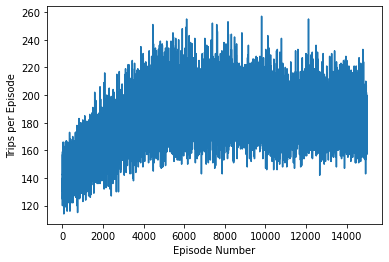

In [0]:
plt.plot(list(range(len(final_trips_per_episode))), final_trips_per_episode)
plt.xlabel("Episode Number")
plt.ylabel("Trips per Episode")

# save plots in saved_plots/ directory
plt.savefig(final_trips_filename)

#### Average trips of last 100 episodes

In [0]:
print("Average trips of last 100 episodes is {0}".format(np.mean(final_trips_per_episode[-100:]))) 

Average trips of last 100 episodes is 181.47


### Offline Actions

#### Reading Offline Actions per episode file

In [0]:
final_offline_actions_per_episode = read_obj(final_offline_actions_per_episode_filename)

#### Plotting episode vs offline actions 

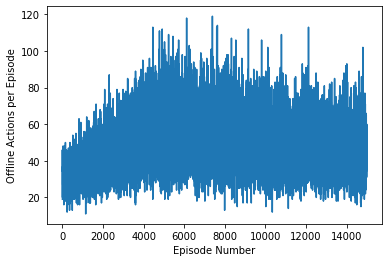

In [0]:
plt.plot(list(range(len(final_offline_actions_per_episode))), final_offline_actions_per_episode)
plt.xlabel("Episode Number")
plt.ylabel("Offline Actions per Episode")

# save plots in saved_plots/ directory
plt.savefig(final_offline_actions_filename)

#### Average offline actions of last 100 episodes

In [0]:
print("Average offline actions of last 100 episodes is {0}".format(np.mean(final_offline_actions_per_episode[-100:]))) 

Average offline actions of last 100 episodes is 45.22


### Loss

#### Reading loss file

In [0]:
final_training_loss = read_obj(final_training_loss_filename)

#### Define loss plot

In [0]:
def plot_loss(loss):        
    plt.title('Loss')
    plt.yscale('log')
    plt.plot(list(range(len(loss))), loss)

    # save plots in saved_plots/ directory
    plt.savefig(final_loss_filename)

#### Plotting loss

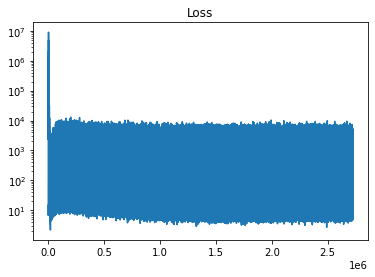

In [0]:
plot_loss(final_training_loss)

### States Tracked

#### Define state actions plot

In [19]:
def plot_state_actions(state_action_pairs, tracked_states, states_tracked_filename, last_tracked_count = None):        
    state_action_values = []
    for state_actions in state_action_pairs:
        state = state_actions[0]
        action = state_actions[1]
        state_action_values.append((state, action, tracked_states[state][action]))

    if last_tracked_count:
        states_tracked_filename = '{}_{}'.format(states_tracked_filename, last_tracked_count) 

    plt.figure(0, figsize=(20,10))
    
    for idx, action_values in enumerate(state_action_values):
        plt.subplot(math.ceil(len(state_action_values) / 3), 3, idx + 1)

        state = action_values[0]
        action = action_values[1]
        values = action_values[2]
        
        tracked_count = last_tracked_count

        if not last_tracked_count:
            plt.yscale('log')
            tracked_count = len(values)

        values_to_plot = values[(-1*tracked_count):]

        plt.title('state={} action={}'.format(state, action))
        plt.plot(list(range(len(values_to_plot))), values_to_plot)

    # save plots in saved_plots/ directory
    states_tracked_filename = states_tracked_filename + '.png'
    plt.savefig(states_tracked_filename)

#### Reading States_tracked file

In [20]:
final_states_track = read_obj(final_all_states_tracked_filename)

#### Most common state-action pairs

##### Getting most common state-action pairs

In [21]:
most_common_state_action_pair, most_common_states_track = populate_common_state_action_track(final_states_track)

most_common_state_action_pair

[('1-19-2', (0, 0), 4772),
 ('1-17-6', (0, 0), 4680),
 ('1-16-6', (0, 0), 4619),
 ('1-18-2', (0, 0), 4422),
 ('1-16-2', (0, 0), 4316)]

##### Saving most common state-action pairs

In [22]:
save_obj(most_common_states_track, final_most_common_states_tracked_filename)

##### Plotting most common state actions

###### Plotting complete state actions

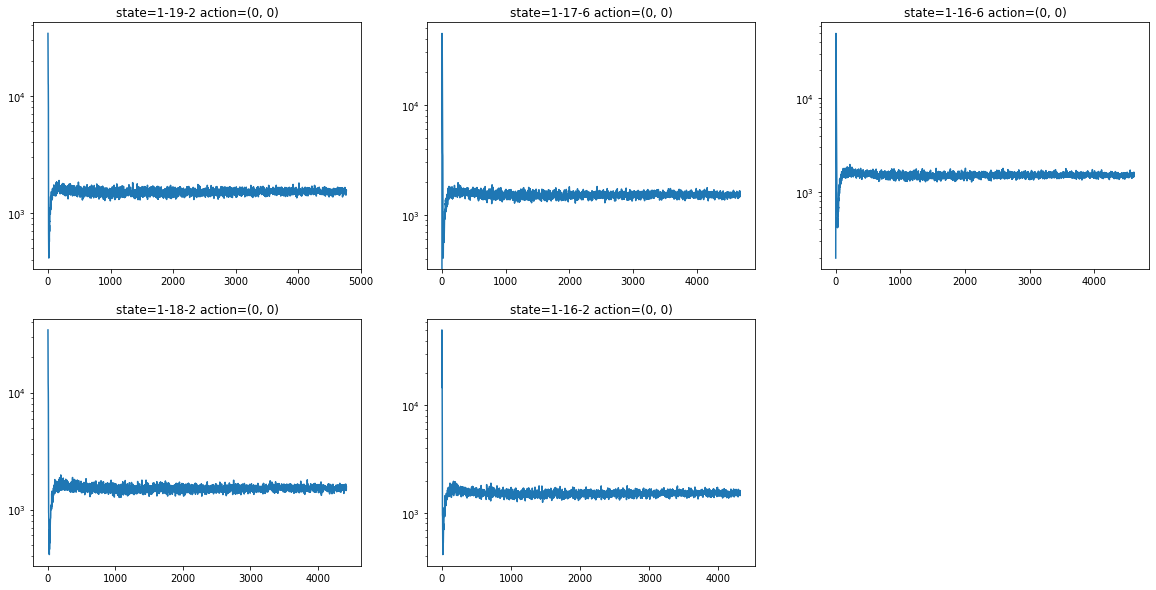

In [23]:
plot_state_actions(most_common_state_action_pair, most_common_states_track, final_most_common_state_actions_filename)

###### Plotting last 1000 state actions

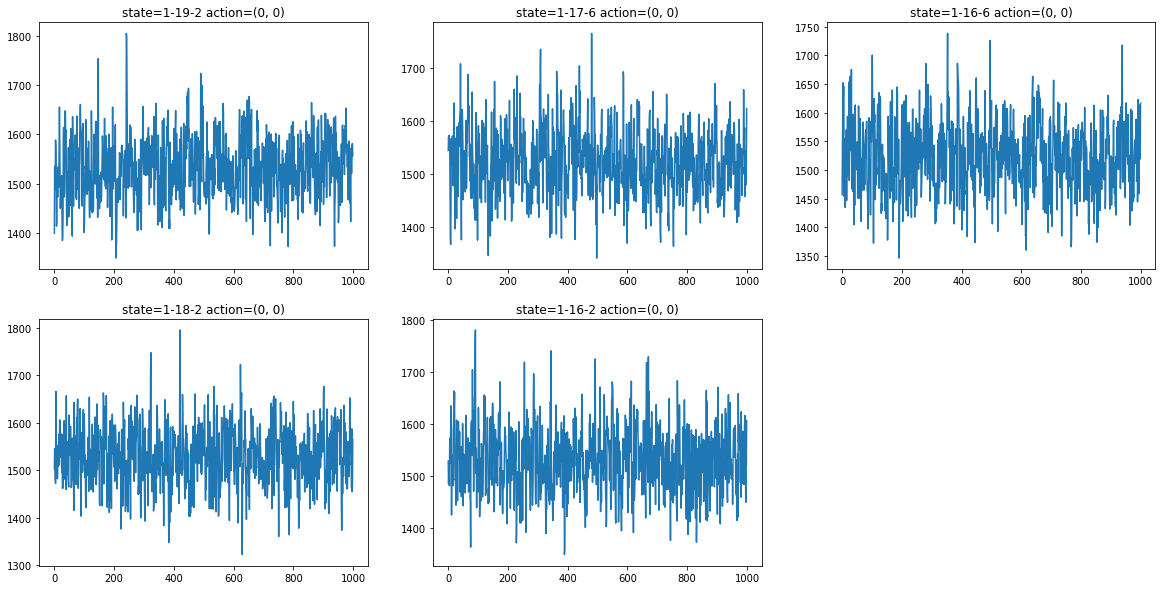

In [24]:
plot_state_actions(most_common_state_action_pair, most_common_states_track, final_most_common_state_actions_filename, 1000)

## Epsilon-decay function

### Sample function
<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

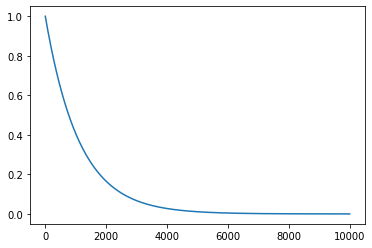

0.4883


In [0]:
episode_steps = np.arange(0,10000)
epsilons = []
for i in range(0,10000):
    epsilons.append(0 + (1 - 0) * np.exp(-0.0009*i))
plt.plot(episode_steps, epsilons)
plt.show()

print(len(list(filter(lambda x: x < 0.01, epsilons)))/len(epsilons))

### Used function

#### Reading epsilons file

In [0]:
final_epsilons = read_obj(final_epsilons_filename)

#### Plotting calculated epsilons

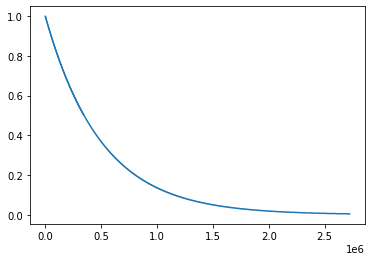

In [0]:
episode_steps = np.arange(0, len(final_epsilons))
plt.plot(episode_steps, final_epsilons)
plt.show()

## Testing Model

### Defining function to test

In [0]:
def test_model(total_available_hours, epsilon = 0, debug = True):
    # Call the environment
    env = CabDriver(Time_matrix, debug = debug)

    # Call all the initialised variables of the environment
    state_size = env.state_size
    action_size = len(env.action_space)

    # Call the DQN agent
    agent = DQNAgent(action_size=action_size, state_size=state_size, debug = debug,
                     epsilon_min = epsilon, 
                    saved_model_path = final_model_filename, is_training = False)

    # Initial state
    state = env.reset()

    total_reward = 0
    total_time_taken = 0
    total_trips = 0

    while total_time_taken < total_available_hours:
        encoded_state = env.state_encod_arch1(state)
            
        possible_actions_index, possible_actions = env.requests(state)
        selected_action_index = agent.get_action(encoded_state, possible_actions_index)[0]
        action = env.action_space[selected_action_index]
            
        next_state, reward, time_taken = env.step(state, action)
            
        total_time_taken += time_taken
        total_reward += reward
        total_trips += 1
        state = next_state

    print('\nTotal time taken is:', total_time_taken)
    print('\nTotal trips taken is:', total_trips)
    print('Total reward is:', total_reward)

### Testing total rewards calculation for 1 complete episode

In [0]:
test_model(24*30, debug = False)


Total time taken is: 724

Total trips taken is: 184
Total reward is: 1618


### Testing request simulation for 1 day

In [0]:
test_model(24)


Time Matrix Shape : (5, 5, 24, 7)

Total Locations : 5

Total no. of hours : 24

Total no. of days : 7

State Size : 36

Action Space Size : 21

Action Space : [(1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (0, 0)]

State Space Size : 840

Location : 4
Encoded Location : [0. 0. 0. 1. 0.]

Time : 11
Encoded Time : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Day : 6
Encoded Day : [0. 0. 0. 0. 0. 0. 1.]

State : (4, 11, 6)
Encoded State : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

Total Requests : 4
Possible Actions Index : [11, 4, 3, 8, 20]
Actions : [(3, 5), (2, 1), (1, 5), (3, 1), (0, 0)]

Action Counter : 1
Epsilon value : 0
Possible Actions Index : [11, 4, 3, 8, 20]
z value : 0.386
Predicted Possible Q-values : [1608.0945, 1614.2634, 1598.4447, 1591.8197, 1615.6195]
Select